# Подключение необходимых библиотек

In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.3 MB/s eta 0:00:00


In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 15.0 MB/s eta 0:00:00


In [3]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 5.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
import torch

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import xgboost

import lightgbm

import openpyxl
from openpyxl import load_workbook

# Набор данных

## Набор данных METLIN

[METLIN](https://figshare.com/articles/dataset/The_METLIN_small_molecule_dataset_for_machine_learning-based_retention_time_prediction/8038913?file=18130628)

Описание:
- inchi - необходимо перевести в SMILES
- rt дано в секундах, поэтому необходимо его перевести в минуты, так как, во-первых, нейронные сети лучше решают задачи с числами меньшего порядка, во-вторых, в других наборах данных колонка rt представлена в минутах.

In [8]:
metlin = pd.read_csv('SMRT_dataset.csv', sep=';', skiprows=[0], header=None)
metlin.columns = ['pubchem', 'rt', 'inchi']

In [11]:
metlin.head()

,pubchem,rt,inchi
0,5139,93.5,"InChI=1S/C3H8N2S/c1-2-6-3(4)5/h2H2,1H3,(H3,4,5)"
1,3505,687.8,InChI=1S/C19H25Cl2N3O3/c1-27-19(26)23-8-9-24(1...
2,2159,590.7,InChI=1S/C17H27N3O4S/c1-4-20-8-6-7-12(20)11-19...
3,1340,583.6,InChI=1S/C9H7NO2/c11-8-3-1-2-7-6(8)4-5-10-9(7)...
4,3344,579.0,InChI=1S/C15H20N2O2/c18-14-16-12-15(19-14)7-10...


Посмотрим распределение данных по параметру rt (retention time):

In [12]:
metlin["rt"].describe()

,rt
count,80038.000000
mean,790.219858
std,206.678769
min,0.300000
25%,661.000000
50%,773.500000
75%,912.500000
max,1471.700000


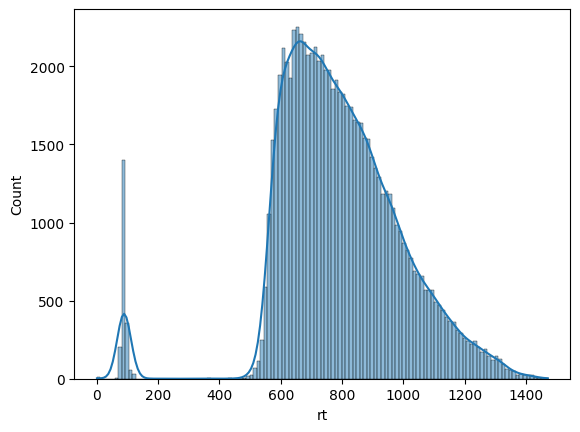

In [13]:
sns.histplot(metlin["rt"], kde=True)
plt.show()

Отсеим все значения, которые больше 400:

In [ ]:
# metlin_bd = metlin.loc[metlin['rt'] > 400]
# print(metlin_bd.shape)
# metlin_bd.index = range(77975)
# metlin_bd

(77975, 3)


,pubchem,rt,inchi
0,3505,687.8,InChI=1S/C19H25Cl2N3O3/c1-27-19(26)23-8-9-24(1...
1,2159,590.7,InChI=1S/C17H27N3O4S/c1-4-20-8-6-7-12(20)11-19...
2,1340,583.6,InChI=1S/C9H7NO2/c11-8-3-1-2-7-6(8)4-5-10-9(7)...
3,3344,579.0,InChI=1S/C15H20N2O2/c18-14-16-12-15(19-14)7-10...
4,2687,603.1,"InChI=1S/C14H21N3O3/c1-14(2,3)15-7-9(18)8-20-1..."
...,...,...,...
77970,97733655,946.4,InChI=1S/C25H29N3O6S/c1-5-24(29)26-25-17(4)27-...
77971,98666786,653.1,InChI=1S/C17H24FN3O5S/c1-25-7-3-6-19-17(22)20-...
77972,98670835,648.2,InChI=1S/C17H25N3O5S/c1-13-4-3-5-16(8-13)26(22...
77973,98779314,783.9,InChI=1S/C21H25N3O4S/c1-15-7-9-19(10-8-15)29(2...


Напишем функцию для перевода из inchi  в smiles:

In [14]:
from rdkit import Chem

def inchi_to_smiles(inchi_str):
    mol = Chem.MolFromInchi(inchi_str)
    if mol:
        return Chem.MolToSmiles(mol)
    else:
        return None

In [16]:
res = []
for item in metlin['inchi']:
    res.append(inchi_to_smiles(item))

[12:23:11] Explicit valence for atom # 14 N, 4, is greater than permitted
[12:23:11] ERROR: Explicit valence for atom # 14 N, 4, is greater than permitted

[12:23:11] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:23:11] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted

[12:23:11] Explicit valence for atom # 16 N, 4, is greater than permitted
[12:23:11] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted

[12:23:11] Explicit valence for atom # 18 N, 4, is greater than permitted
[12:23:11] ERROR: Explicit valence for atom # 18 N, 4, is greater than permitted

[12:23:11] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:23:11] ERROR: Explicit valence for atom # 17 N, 4, is greater than permitted

[12:23:11] Explicit valence for atom # 15 N, 4, is greater than permitted
[12:23:11] ERROR: Explicit valence for atom # 15 N, 4, is greater than permitted

[12:23:11] Explicit valence for atom # 16 N, 4, is greater than 

In [17]:
metlin.insert(3, 'smiles', res)

In [33]:
metlin

,pubchem,rt,inchi,smiles
0,5139,93.5,"InChI=1S/C3H8N2S/c1-2-6-3(4)5/h2H2,1H3,(H3,4,5)",CCSC(=N)N
1,3505,687.8,InChI=1S/C19H25Cl2N3O3/c1-27-19(26)23-8-9-24(1...,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...
2,2159,590.7,InChI=1S/C17H27N3O4S/c1-4-20-8-6-7-12(20)11-19...,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1OC
3,1340,583.6,InChI=1S/C9H7NO2/c11-8-3-1-2-7-6(8)4-5-10-9(7)...,Oc1cccc2c(O)nccc12
4,3344,579.0,InChI=1S/C15H20N2O2/c18-14-16-12-15(19-14)7-10...,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1
...,...,...,...,...
80033,97733655,946.4,InChI=1S/C25H29N3O6S/c1-5-24(29)26-25-17(4)27-...,CCOc1ccc(OCC)c(NS(=O)(=O)c2ccc(/C=C/c3onc(C)c3...
80034,98666786,653.1,InChI=1S/C17H24FN3O5S/c1-25-7-3-6-19-17(22)20-...,COCCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(F)c3)C...
80035,98670835,648.2,InChI=1S/C17H25N3O5S/c1-13-4-3-5-16(8-13)26(22...,COCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(C)c3)C[...
80036,98779314,783.9,InChI=1S/C21H25N3O4S/c1-15-7-9-19(10-8-15)29(2...,Cc1ccc(S(=O)(=O)N2C[C@@H]3CN(C(O)=Nc4ccccc4C)C...


Удалим все строки, для которых не удалось произвести конвертацию InChI в SMILES:

In [20]:
metlin.isna().sum()

,0
pubchem,0
rt,0
inchi,0
smiles,81


In [34]:
metlin = metlin.dropna()
metlin_data = metlin[['smiles', 'rt']]
metlin_data.loc[:, 'rt'] = metlin_data['rt'].apply(lambda x: x / 60)
metlin_data

,smiles,rt
0,CCSC(=N)N,1.558333
1,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,11.463333
2,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1OC,9.845000
3,Oc1cccc2c(O)nccc12,9.726667
4,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1,9.650000
...,...,...
80033,CCOc1ccc(OCC)c(NS(=O)(=O)c2ccc(/C=C/c3onc(C)c3...,15.773333
80034,COCCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(F)c3)C...,10.885000
80035,COCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(C)c3)C[...,10.803333
80036,Cc1ccc(S(=O)(=O)N2C[C@@H]3CN(C(O)=Nc4ccccc4C)C...,13.065000


In [35]:
metlin_data.isna().sum()

,0
smiles,0
rt,0


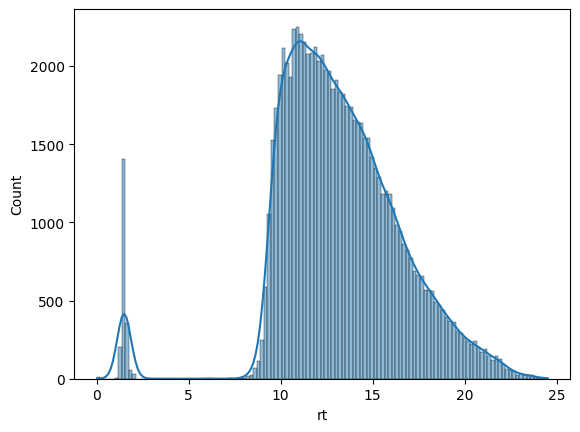

In [36]:
sns.histplot(metlin_data["rt"], kde=True)
plt.show()

In [37]:
metlin_data.to_csv('METLIN_all_SMILES_RT_seconds_Kate', index=False)

Теперь перекодируем SMILES в векторный вид:

In [ ]:
#metlin_data = pd.read_csv('METLIN_all_SMILES_RT_seconds_Kate')

In [38]:
metlin_data

,smiles,rt
0,CCSC(=N)N,1.558333
1,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,11.463333
2,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1OC,9.845000
3,Oc1cccc2c(O)nccc12,9.726667
4,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1,9.650000
...,...,...
80033,CCOc1ccc(OCC)c(NS(=O)(=O)c2ccc(/C=C/c3onc(C)c3...,15.773333
80034,COCCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(F)c3)C...,10.885000
80035,COCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(C)c3)C[...,10.803333
80036,Cc1ccc(S(=O)(=O)N2C[C@@H]3CN(C(O)=Nc4ccccc4C)C...,13.065000


## Набор данных HILIC

In [43]:
workbook = load_workbook('ac9b05765_si_001.xlsx')

In [45]:
hilic = pd.DataFrame(workbook['Table_S1_Training_HILIC'].values)
hilic = hilic.loc[3:, [2, 3]]
hilic.columns = ['smiles', 'rt']
hilic.index = range(880)

In [46]:
hilic

,smiles,rt
0,C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O,2.019083
1,CC1C(NC(CN1)C2=CC=CC=C2)C,2.60795
2,C1CCC(C(C1)O)O,4.87655
3,C1CCC(=O)C(=O)C1,5.772267
4,CN1C2=C(NC1=O)N(C(=O)N(C2=O)C)C,1.827733
...,...,...
875,CC1CC2=C(CCC(=O)C2)C3C1C4CCC(C4(CC3)C)(C#C)O,0.995283
876,C1=CC(=CC=C1C=CC2=CC(=CC(=C2)OC3C(C(C(C(O3)CO)...,4.640017
877,C(C1C(C(C(C(O1)OC2C(C(C(C(O2)COP(=O)(O)O)O)O)O...,9.717716
878,C1CC(=O)C(C=C1)(C(=O)OCC2=CC=CC=C2OC3C(C(C(C(O...,1.507783


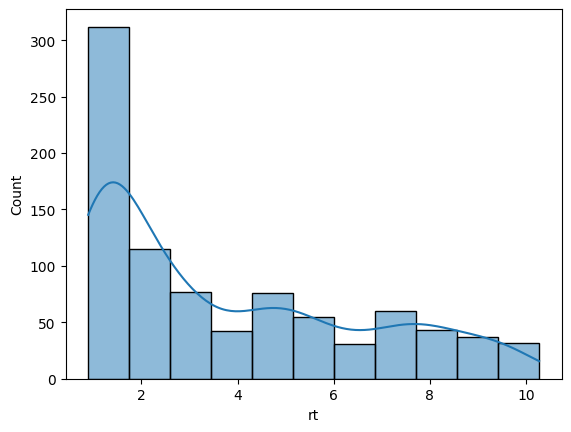

In [47]:
sns.histplot(hilic["rt"], kde=True)
plt.show()

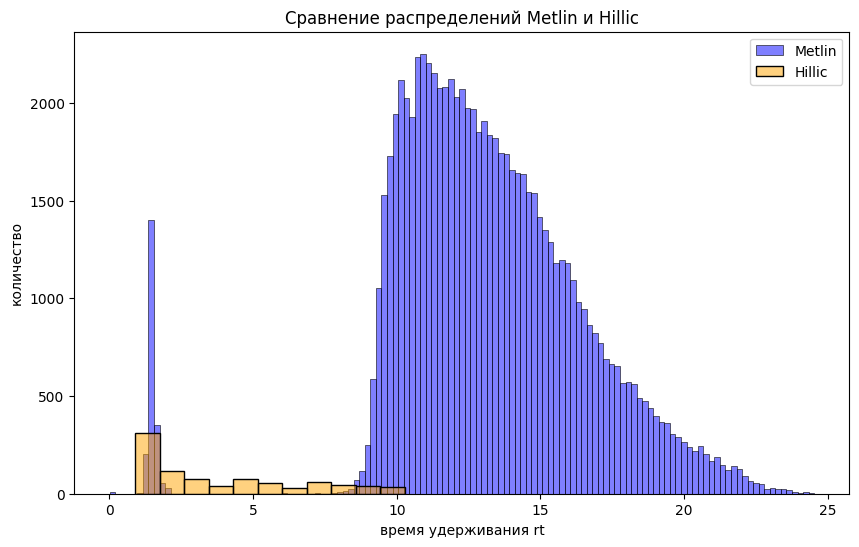

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Создаем фигуру и ось
plt.figure(figsize=(10, 6))

# Сначала строим распределение для metlin
sns.histplot(metlin_data['rt'], label='Metlin', color='blue', fill=True, alpha=0.5)

# Затем строим распределение для hilic
sns.histplot(hilic['rt'], label='Hillic', color='orange', fill=True, alpha=0.5)

# Добавляем заголовки и подписи
plt.title('Сравнение распределений Metlin и Hillic')
plt.xlabel('время удерживания rt')
plt.ylabel('количество')

# Добавляем легенду
plt.legend()

# Показываем график
plt.show()

In [62]:
symbols_metlin = set(''.join(metlin_data['smiles']))
symbols_hilic = set(''.join(hilic['smiles']))
print(len(symbols_metlin), len(symbols_hilic))

36 29


In [66]:
symbols = symbols_metlin.union(symbols_hilic)
symbols.add(' ')
print('Количество уникальных символов: ', len(symbols))
print('Сами уникальные символы: ', ' '.join(symbols))

Количество уникальных символов:  37
Сами уникальные символы:  / [ B o \ I 7 l c - 1 r @   5 8 s O N ( ) # ] H = C 3 n 6 S 4 F 2 + 9 P i


In [67]:
lengths_metlin = [len(sent) for sent in metlin_data['smiles']]
lengths_hilic = [len(sent) for sent in hilic['smiles']]
maxlen = max(max(lengths_metlin), max(lengths_hilic))
print(f"The longest string has {maxlen} characters.\n")

The longest string has 185 characters.



In [68]:
for i in range(77895):
    if len(metlin_data['smiles'].values[i]) < maxlen:
        metlin_data['smiles'].values[i] = metlin_data['smiles'].values[i].ljust(maxlen)

for i in range(880):
    if len(hilic['smiles'].values[i]) < maxlen:
        hilic['smiles'].values[i] = hilic['smiles'].values[i].ljust(maxlen)

In [70]:
metlin_data.head()

,smiles,rt
0,CCSC(=N)N ...,1.558333
1,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,11.463333
2,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1O...,9.845000
3,Oc1cccc2c(O)nccc12 ...,9.726667
4,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1 ...,9.650000


In [71]:
hilic.head()

,smiles,rt
0,C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O ...,2.019083
1,CC1C(NC(CN1)C2=CC=CC=C2)C ...,2.60795
2,C1CCC(C(C1)O)O ...,4.87655
3,C1CCC(=O)C(=O)C1 ...,5.772267
4,CN1C2=C(NC1=O)N(C(=O)N(C2=O)C)C ...,1.827733


In [78]:
metlin_data.to_csv('METLIN_to_OHE_to_CNN', index=False)
hilic.to_csv('HILIC_to_OHE_to_CNN', index=False)

### One hot encoding

In [72]:
char_to_index = {char: idx for idx, char in enumerate(set_unique)}
num_unique_chars = len(set_unique)

def smiles_to_one_hot(smiles, char_to_index, num_unique_chars):
    one_hot = np.zeros((len(smiles), num_unique_chars), dtype=np.float32)
    for i, char in enumerate(smiles):
        one_hot[i, char_to_index[char]] = 1
    return np.transpose(one_hot)

In [73]:
metlin_one_hot = []
for smile in metlin_data['smiles']:
    metlin_one_hot.append(smiles_to_one_hot(smile, char_to_index, num_unique_chars))

In [74]:
hilic_one_hot = []
for smile in hilic['smiles']:
    hilic_one_hot.append(smiles_to_one_hot(smile, char_to_index, num_unique_chars))

In [75]:
metlin_one_hot[1].shape

(37, 185)

In [77]:
hilic_one_hot[1].shape

(37, 185)

In [ ]:
metlin_tensor_hot = [torch.tensor(metlin_one_hot[i]) for i in range(77895)]
hilic_tensor_hot = [torch.tensor(hilic_one_hot[i]) for i in range(800)]

Теперь набор данных готов к подаче в нейронную сеть.